In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
datadir='/content/drive/MyDrive'
os.chdir(datadir)

In [3]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch

class DriverSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        self.image_list = []
        self.label_list = []
        
        if self.mode == 'train':
            for class_name in os.listdir(os.path.join(self.root_dir, 'train')):
                class_id = int(class_name[1])
                class_path = os.path.join(self.root_dir, 'train', class_name)
                
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    
                    if os.path.exists(img_path):
                        self.image_list.append(img_path)
                        self.label_list.append(class_id)
                    else:
                        print(f"Warning: Image not found: {img_path}")

        elif self.mode == 'val':
            for class_name in os.listdir(os.path.join(self.root_dir, 'val')):
                class_id = int(class_name[1])
                class_path = os.path.join(self.root_dir, 'val', class_name)
                
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    
                    if os.path.exists(img_path):
                        self.image_list.append(img_path)
                        self.label_list.append(class_id)
                    else:
                        print(f"Warning: Image not found: {img_path}")
                        
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.label_list[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [4]:
import torchvision.transforms as transforms

# Define train and test transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define train and val datasets
train_dataset = DriverSegmentationDataset('/content/drive/MyDrive/final', transform=train_transforms, mode='train')
val_dataset = DriverSegmentationDataset('/content/drive/MyDrive/final', transform=val_transforms, mode='val')

# Define train and val dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:03<00:00, 61.8MB/s]


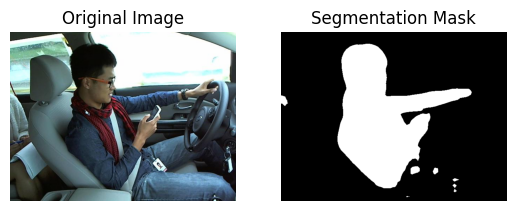

In [6]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models.segmentation import deeplabv3_resnet101
import torchvision.models as models

# Load the pre-trained model
model = models.segmentation.fcn_resnet101(pretrained=True, progress=True).to(device)

# Set the model to evaluation mode
model.eval()

# Define a function to perform inference on an image and return the segmentation mask
def segment_person(image):
    with torch.no_grad():
        # Convert the image to a PyTorch tensor
        if not isinstance(image, torch.Tensor):
          image = transforms.ToTensor()(image)
        image = image.to(device)
        # Add a batch dimension to the tensor
        image = image.unsqueeze(0)
        # Run the model on the input image
        output = model(image)['out'][0]
        # Get the segmentation mask for the person class (class 15)
        mask = output.argmax(dim=0)
        mask = (mask == 15).float().cpu().numpy()
    return mask

# Load a sample image
image = Image.open('/content/drive/MyDrive/img_928.jpg')

# Perform segmentation on the image
mask = segment_person(image)

# Display the original image and the segmentation mask side by side
import matplotlib.pyplot as plt
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(mask, cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.show()

In [10]:
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim

model_cnn = torchvision.models.resnet18(pretrained=True)

accuracies = []
losses = []
epochs = []

for param in model_cnn.parameters():
    param.requires_grad = False

num_classes = 10
model_cnn.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_cnn.fc = nn.Linear(model_cnn.fc.in_features, num_classes)

model_cnn.eval()
model_cnn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.fc.parameters(), lr=0.001)

# Train the model for n epochs
n_epochs = 50
for epoch in range(n_epochs):
    running_loss = 0.0
    running_corrects = 0.0
    total_samples = 0.0
    i =0
    for images, labels in train_loader:
        # Segment the person in each image
        images = images.to(device)
        masks = []
        for image in images:
            mask = segment_person(image)
            masks.append(mask)
        masks = np.stack(masks)

        # Use the segmentation masks as input to the pre-trained model
        inputs = torch.from_numpy(masks).unsqueeze(1).float().to(device)

        # Pass the input through the classification model
        outputs = model_cnn(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data.to(device))
        total_samples += images.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    accuracies.append(epoch_acc)
    losses.append(epoch_loss)
    epochs.append(epoch+1)
    print(f'Epoch {epoch + 1}/{n_epochs}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

Epoch 1/50: Loss: 2.1248, Accuracy: 0.2661
Epoch 2/50: Loss: 1.8073, Accuracy: 0.4420
Epoch 3/50: Loss: 1.6270, Accuracy: 0.5033
Epoch 4/50: Loss: 1.5174, Accuracy: 0.5408
Epoch 5/50: Loss: 1.4317, Accuracy: 0.5611
Epoch 6/50: Loss: 1.3669, Accuracy: 0.5782
Epoch 7/50: Loss: 1.3214, Accuracy: 0.5942
Epoch 8/50: Loss: 1.2710, Accuracy: 0.6080
Epoch 9/50: Loss: 1.2325, Accuracy: 0.6215
Epoch 10/50: Loss: 1.2006, Accuracy: 0.6297
Epoch 11/50: Loss: 1.1670, Accuracy: 0.6454
Epoch 12/50: Loss: 1.1435, Accuracy: 0.6543
Epoch 13/50: Loss: 1.1140, Accuracy: 0.6656
Epoch 14/50: Loss: 1.0926, Accuracy: 0.6673
Epoch 15/50: Loss: 1.0711, Accuracy: 0.6766
Epoch 16/50: Loss: 1.0539, Accuracy: 0.6800
Epoch 17/50: Loss: 1.0360, Accuracy: 0.6966
Epoch 18/50: Loss: 1.0144, Accuracy: 0.7024
Epoch 19/50: Loss: 1.0011, Accuracy: 0.7031
Epoch 20/50: Loss: 0.9883, Accuracy: 0.7050
Epoch 21/50: Loss: 0.9722, Accuracy: 0.7117
Epoch 22/50: Loss: 0.9597, Accuracy: 0.7183
Epoch 23/50: Loss: 0.9458, Accuracy: 0.72

In [11]:
torch.save(model_cnn.state_dict(), '/content/drive/MyDrive/model_cnn_gray_244_dict.pth')

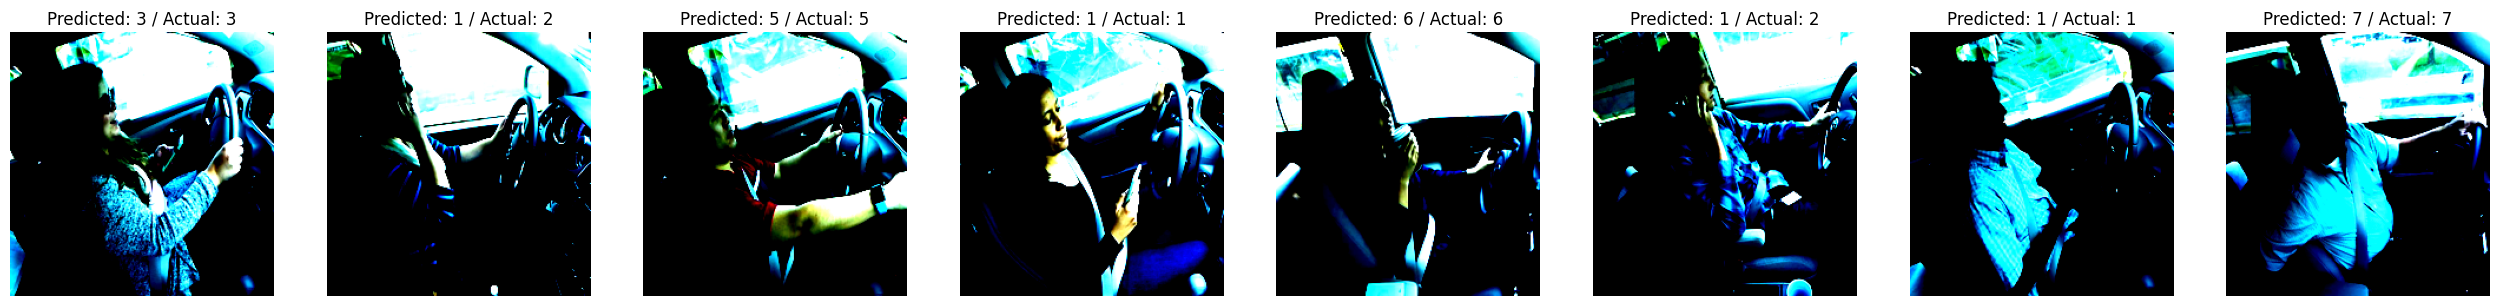

In [12]:
model_cnn.eval()

# Get a few images from test loader
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

# Predict labels for the images
with torch.no_grad():
    masks = []
    for image in images:
        mask = segment_person(image)
        masks.append(mask)
    masks = np.stack(masks)
    inputs = torch.from_numpy(masks).unsqueeze(1).float().to(device)
    outputs = model_cnn(inputs)
    _, predicted = torch.max(outputs.data, 1)

# Convert tensor labels to numpy array
labels_np = labels[:8].cpu().numpy()
predicted_np = predicted[:8].cpu().numpy()

# Visualize the images and predicted labels
fig, axs = plt.subplots(1, len(labels_np), figsize=(32, 32))
for i in range(len(labels_np)):
    img = images[i].cpu().numpy().transpose((1, 2, 0))
    img = np.squeeze(img)
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Predicted: {predicted_np[i]} / Actual: {labels_np[i]}')
plt.show()

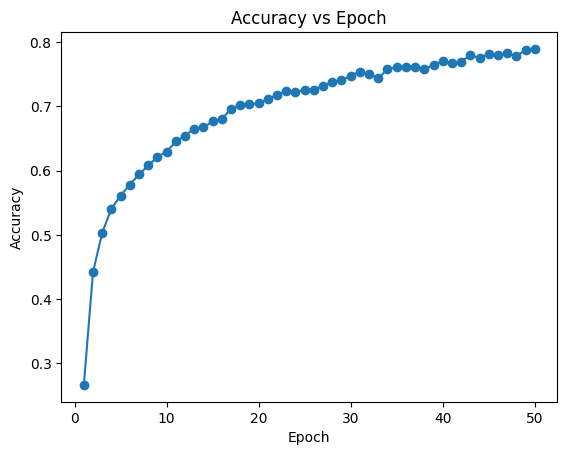

In [13]:
import matplotlib.pyplot as plt

accuracies = [t.cpu() for t in accuracies]

plt.plot(epochs, accuracies, marker='o')

# set the title and labels
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# display the plot
plt.show()

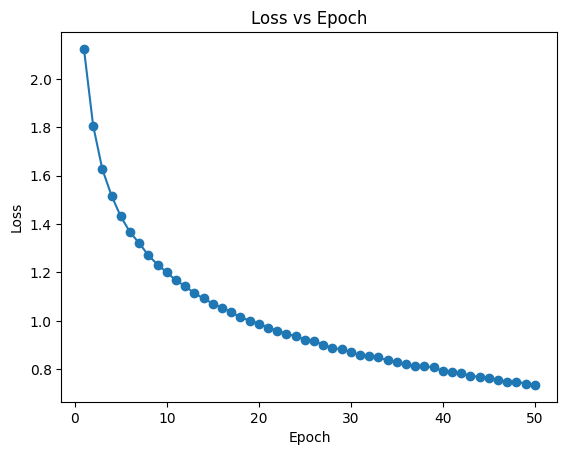

In [14]:
plt.plot(epochs, losses, marker='o')

# set the title and labels
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# display the plot
plt.show()

In [15]:
# Test the model
model_cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        masks = []
        for image in images:
            mask = segment_person(image)
            masks.append(mask)
        masks = np.stack(masks)
        inputs = torch.from_numpy(masks).unsqueeze(1).float().to(device)
        outputs = model_cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = correct / total
print(f'Validation Acc: {val_acc:.4f}')


Validation Acc: 0.7309
